<a href="https://colab.research.google.com/github/Fayli775/INFOSYS722-Iteration4/blob/main/07_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Environment Setup
!apt-get install openjdk-11-jdk-headless -qq
!pip install -q pyspark findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Step7_DataMining").getOrCreate()

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import functions as F
from pyspark.sql.functions import col, mean, stddev, count, when, max as spark_max, min as spark_min
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Step 7 Environment Setup Complete")

Mounted at /content/drive
Step 7 Environment Setup Complete


In [3]:
print("=" * 80)
print("7.1 LOGICAL TEST DESIGNS")
print("=" * 80)

print("\n7.1.1 Validation of Section 6.3 Test Design Framework")
print("-" * 55)

print("This section implements the test design framework established in Section 6.3,")
print("where a 70/30 split with fixed random seed (42) was specified for both")
print("Decision Tree and K-Means model evaluation.")

print("\n7.1.2 70/30 Split Justification")
print("-" * 35)

# Validate split ratios
total_records = 1371877
train_size_70 = int(total_records * 0.7)
test_size_30 = int(total_records * 0.3)

print("Primary Split Selection:")
print(f"A 70/30 training/testing split provides practical balance between")
print(f"training adequacy and evaluation reliability.")
print(f"  Training: {train_size_70:,} records (sufficient for Decision Tree learning)")
print(f"  Testing: {test_size_30:,} records (reliable statistical evaluation)")

# Statistical power calculation
margin_of_error = 1.96 * np.sqrt(0.25 / test_size_30)
print(f"  Statistical Margin of Error: {margin_of_error:.4f}")

print("\nAlternative Split Rejection:")
print("- 80/20 Split: Would reduce test sample, making evaluation more variable")
print("- 60/40 Split: Would limit training data, compromising model learning")
print("- Cross-validation: Single holdout better simulates deployment scenarios")

print("\n7.1.3 Algorithm-Specific Requirements")
print("-" * 40)

print("Decision Tree Evaluation:")
print("- Large training set enables categorical interaction learning")
print("- Substantial test set provides reliable generalization assessment")
print("- Conservative parameters work with 70/30 to prevent overfitting")

print("\nK-Means Clustering Evaluation:")
print("- Applied to complete dataset (unsupervised learning)")
print("- No train/test split required for model fitting")
print("- Full dataset maximizes cluster stability and reliability")

print("\n7.1.4 Reproducibility Controls")
print("-" * 30)

print("Fixed random seed (42) ensures:")
print("- Identical data partitions across all runs")
print("- Reproducible results for academic validation")
print("- Fair comparison between model configurations")

print("\nConclusion: 70/30 split balances training capacity with evaluation")
print("reliability, ensures reproducibility, and supports both supervised")
print("and unsupervised learning requirements.")

7.1 LOGICAL TEST DESIGNS

7.1.1 Validation of Section 6.3 Test Design Framework
-------------------------------------------------------
This section implements the test design framework established in Section 6.3,
where a 70/30 split with fixed random seed (42) was specified for both
Decision Tree and K-Means model evaluation.

7.1.2 70/30 Split Justification
-----------------------------------
Primary Split Selection:
A 70/30 training/testing split provides practical balance between
training adequacy and evaluation reliability.
  Training: 960,313 records (sufficient for Decision Tree learning)
  Testing: 411,563 records (reliable statistical evaluation)
  Statistical Margin of Error: 0.0015

Alternative Split Rejection:
- 80/20 Split: Would reduce test sample, making evaluation more variable
- 60/40 Split: Would limit training data, compromising model learning
- Cross-validation: Single holdout better simulates deployment scenarios

7.1.3 Algorithm-Specific Requirements
-------------

In [4]:
print("\n" + "=" * 80)
print("7.2 DATA MINING EXECUTION")
print("=" * 80)

print("\n7.2.1 Data Loading and Pipeline Setup")
print("-" * 40)

# Load dataset using exact Step 6 approach
input_path = "/content/drive/MyDrive/722/output/05_projected_final.parquet"
df_modeling = spark.read.parquet(input_path)

# Define variables exactly as Step 6
COL_TARGET = "Traffic Count"
categorical_features = ['Class Weight', 'Flow Direction', 'weekday']
RANDOM_SEED = 42

print("Dataset Successfully Loaded:")
print(f"Total Records: {df_modeling.count():,}")
print(f"Target Variable: {COL_TARGET}")
print(f"Categorical Features: {categorical_features}")

# Apply exact same split as Step 6.1
train_df, test_df = df_modeling.randomSplit([0.7, 0.3], seed=RANDOM_SEED)
train_df.cache()
test_df.cache()

print(f"\nData Split Applied (Step 6.3 Configuration):")
print(f"Training Set: {train_df.count():,} records")
print(f"Test Set: {test_df.count():,} records")
print(f"Split Verification: {train_df.count() + test_df.count():,} total")

# Show schema for Figure 7-1
print(f"\nDataset Schema:")
df_modeling.printSchema()



7.2 DATA MINING EXECUTION

7.2.1 Data Loading and Pipeline Setup
----------------------------------------
Dataset Successfully Loaded:
Total Records: 1,371,877
Target Variable: Traffic Count
Categorical Features: ['Class Weight', 'Flow Direction', 'weekday']

Data Split Applied (Step 6.3 Configuration):
Training Set: 960,778 records
Test Set: 411,099 records
Split Verification: 1,371,877 total

Dataset Schema:
root
 |-- Traffic Count: double (nullable = true)
 |-- Log_Traffic_Count: double (nullable = true)
 |-- Class Weight: string (nullable = true)
 |-- Flow Direction: string (nullable = true)
 |-- weekday: string (nullable = true)


FIGURE 7-1: Dataset Schema and Sample Data
Take screenshot of above schema output


In [7]:
print(f"\nSample Data:")
df_modeling.show(5, truncate=False)


Sample Data:
+-------------+-----------------+------------+--------------+-------+
|Traffic Count|Log_Traffic_Count|Class Weight|Flow Direction|weekday|
+-------------+-----------------+------------+--------------+-------+
|18585.0      |9.830163888117285|Light       |2             |Thu    |
|924.0        |6.829793737512425|Heavy       |1             |Thu    |
|18508.0      |9.826012379256717|Light       |1             |Thu    |
|930.0        |6.836259277277067|Heavy       |2             |Thu    |
|938.0        |6.844815479208263|Heavy       |2             |Fri    |
+-------------+-----------------+------------+--------------+-------+
only showing top 5 rows



In [5]:
print("\n7.2.2 Decision Tree Model Execution")
print("-" * 40)

# Build Decision Tree pipeline - EXECUTION ONLY
stages_dt = []

print("Building Decision Tree Pipeline:")
print("Step 1: String Indexing for Categorical Features")
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_idx",
        handleInvalid="keep"
    )
    stages_dt.append(indexer)
    print(f"  - {feature} → {feature}_idx")

print("Step 2: Feature Vector Assembly")
assembler_dt = VectorAssembler(
    inputCols=[f"{f}_idx" for f in categorical_features],
    outputCol="features"
)
stages_dt.append(assembler_dt)

print("Step 3: Decision Tree Configuration")
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol=COL_TARGET,
    predictionCol="dt_prediction",
    maxDepth=10,
    minInstancesPerNode=20,
    maxBins=32,
    seed=RANDOM_SEED
)
stages_dt.append(dt)

print("Decision Tree Parameters Applied:")
print(f"  - Max Depth: 10")
print(f"  - Min Instances Per Node: 20")
print(f"  - Max Bins: 32")
print(f"  - Random Seed: {RANDOM_SEED}")

# Train model - SHOW EXECUTION EVIDENCE ONLY
dt_pipeline = Pipeline(stages=stages_dt)
print("\n>>> Training Decision Tree Model...")
dt_model = dt_pipeline.fit(train_df)
print(">>> Decision Tree Training Completed Successfully")

# Generate predictions - SHOW EVIDENCE ONLY
train_predictions_dt = dt_model.transform(train_df)
test_predictions_dt = dt_model.transform(test_df)

print("\n>>> Predictions Generated:")
print(f"Training Predictions: {train_predictions_dt.count():,} records")
print(f"Test Predictions: {test_predictions_dt.count():,} records")

print("\n" + "="*60)
print("FIGURE 7-2: Decision Tree Execution Evidence")
print("="*60)
print("Take screenshot of pipeline configuration and training completion")
print("="*60)

# Show sample predictions table for evidence
print("\nSample Prediction Output (Evidence of Model Execution):")
sample_predictions = test_predictions_dt.select(
    COL_TARGET, "dt_prediction"
).sample(0.001, seed=42)
sample_predictions.show(5, truncate=False)


7.2.2 Decision Tree Model Execution
----------------------------------------
Building Decision Tree Pipeline:
Step 1: String Indexing for Categorical Features
  - Class Weight → Class Weight_idx
  - Flow Direction → Flow Direction_idx
  - weekday → weekday_idx
Step 2: Feature Vector Assembly
Step 3: Decision Tree Configuration
Decision Tree Parameters Applied:
  - Max Depth: 10
  - Min Instances Per Node: 20
  - Max Bins: 32
  - Random Seed: 42

>>> Training Decision Tree Model...
>>> Decision Tree Training Completed Successfully

>>> Predictions Generated:
Training Predictions: 960,778 records
Test Predictions: 411,099 records

FIGURE 7-2: Decision Tree Execution Evidence
Take screenshot of pipeline configuration and training completion

Sample Prediction Output (Evidence of Model Execution):
+-------------+------------------+
|Traffic Count|dt_prediction     |
+-------------+------------------+
|74.5         |901.9355786053486 |
|75.0         |502.9321478382148 |
|76.5         |502.

In [6]:
print("\n7.2.3 K-Means Clustering Model Execution")
print("-" * 45)

# Build K-Means preprocessing pipeline - EXECUTION ONLY
stages_kmeans = []

print("Building K-Means Pipeline:")
print("Step 1: Categorical Feature Indexing")
indexed_cols_kmeans = []
for feature in categorical_features:
    indexer = StringIndexer(
        inputCol=feature,
        outputCol=f"{feature}_kmeans_idx",
        handleInvalid="keep"
    )
    stages_kmeans.append(indexer)
    indexed_cols_kmeans.append(f"{feature}_kmeans_idx")
    print(f"  - {feature} → {feature}_kmeans_idx")

print("Step 2: Feature Vector Assembly")
assembler_kmeans = VectorAssembler(
    inputCols=indexed_cols_kmeans,
    outputCol="features_raw"
)
stages_kmeans.append(assembler_kmeans)

print("Step 3: Feature Standardization")
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_kmeans",
    withStd=True,
    withMean=True
)
stages_kmeans.append(scaler)

# Apply preprocessing - SHOW EXECUTION EVIDENCE
kmeans_preprocessing = Pipeline(stages=stages_kmeans)
kmeans_preprocessing_fitted = kmeans_preprocessing.fit(df_modeling)
df_kmeans_ready = kmeans_preprocessing_fitted.transform(df_modeling)

print(">>> Preprocessing Pipeline Completed:")
print(f"Records Processed: {df_kmeans_ready.count():,}")
print(f"Features Standardized: {len(indexed_cols_kmeans)}")

# Apply K-Means with optimal parameters from Step 6.1
optimal_k = 14
print(f"\nStep 4: K-Means Clustering Configuration (K={optimal_k})")

kmeans_model = KMeans(
    featuresCol="features_kmeans",
    predictionCol="kmeans_prediction",
    k=optimal_k,
    seed=RANDOM_SEED,
    maxIter=100,
    tol=1e-4
)

print("K-Means Parameters Applied:")
print(f"  - Number of Clusters (K): {optimal_k}")
print(f"  - Max Iterations: 100")
print(f"  - Tolerance: 1e-4")
print(f"  - Random Seed: {RANDOM_SEED}")

print("\n>>> Training K-Means Model...")
kmeans_fitted = kmeans_model.fit(df_kmeans_ready)
kmeans_predictions = kmeans_fitted.transform(df_kmeans_ready)
print(">>> K-Means Training Completed Successfully")

print(f"\n>>> Clustering Results Generated:")
print(f"Total Records Clustered: {kmeans_predictions.count():,}")
print(f"Clusters Generated: {optimal_k}")

print("\n" + "="*60)
print("FIGURE 7-3: K-Means Execution Evidence")
print("="*60)
print("Take screenshot of preprocessing completion and clustering results")
print("="*60)

# Show cluster assignment evidence
print("\nSample Cluster Assignments (Evidence of Model Execution):")
cluster_sample = kmeans_predictions.select(
    "Class Weight", "Flow Direction", "weekday", "kmeans_prediction"
).sample(0.001, seed=42)
cluster_sample.show(5, truncate=False)


7.2.3 K-Means Clustering Model Execution
---------------------------------------------
Building K-Means Pipeline:
Step 1: Categorical Feature Indexing
  - Class Weight → Class Weight_kmeans_idx
  - Flow Direction → Flow Direction_kmeans_idx
  - weekday → weekday_kmeans_idx
Step 2: Feature Vector Assembly
Step 3: Feature Standardization
>>> Preprocessing Pipeline Completed:
Records Processed: 1,371,877
Features Standardized: 3

Step 4: K-Means Clustering Configuration (K=14)
K-Means Parameters Applied:
  - Number of Clusters (K): 14
  - Max Iterations: 100
  - Tolerance: 1e-4
  - Random Seed: 42

>>> Training K-Means Model...
>>> K-Means Training Completed Successfully

>>> Clustering Results Generated:
Total Records Clustered: 1,371,877
Clusters Generated: 14

FIGURE 7-3: K-Means Execution Evidence
Take screenshot of preprocessing completion and clustering results

Sample Cluster Assignments (Evidence of Model Execution):
+------------+--------------+-------+-----------------+
|Class 

In [8]:
print("\n\n" + "=" * 80)
print("7.3 SEARCH FOR PATTERNS AND MODEL OUTPUT DOCUMENTATION")
print("=" * 80)

print("\n7.3.1 Decision Tree Model Output")
print("-" * 35)

# Calculate all performance metrics
evaluator_r2 = RegressionEvaluator(labelCol=COL_TARGET, predictionCol="dt_prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol=COL_TARGET, predictionCol="dt_prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol=COL_TARGET, predictionCol="dt_prediction", metricName="rmse")

train_r2_dt = evaluator_r2.evaluate(train_predictions_dt)
test_r2_dt = evaluator_r2.evaluate(test_predictions_dt)
train_mae_dt = evaluator_mae.evaluate(train_predictions_dt)
test_mae_dt = evaluator_mae.evaluate(test_predictions_dt)
train_rmse_dt = evaluator_rmse.evaluate(train_predictions_dt)
test_rmse_dt = evaluator_rmse.evaluate(test_predictions_dt)

train_corr_dt = train_predictions_dt.select(F.corr(COL_TARGET, "dt_prediction").alias("correlation")).collect()[0]["correlation"]
test_corr_dt = test_predictions_dt.select(F.corr(COL_TARGET, "dt_prediction").alias("correlation")).collect()[0]["correlation"]

print("Performance Metrics:")
print(f"Training R² = {train_r2_dt:.4f}")
print(f"Test R² = {test_r2_dt:.4f}")
print(f"Training Correlation = {train_corr_dt:.4f}")
print(f"Test Correlation = {test_corr_dt:.4f}")
print(f"Training MAE = {train_mae_dt:.1f}")
print(f"Test MAE = {test_mae_dt:.1f}")
print(f"Training RMSE = {train_rmse_dt:.1f}")
print(f"Test RMSE = {test_rmse_dt:.1f}")
print(f"Overfitting Gap = {abs(train_r2_dt - test_r2_dt):.4f}")

# Feature importance
dt_final_model = dt_model.stages[-1]
feature_importances = dt_final_model.featureImportances.toArray()
feature_names = [f.replace('_idx', '') for f in [f"{f}_idx" for f in categorical_features]]

print(f"\nModel Structure:")
print(f"Total Nodes = {dt_final_model.numNodes}")
print(f"Tree Depth = {dt_final_model.depth}")

print(f"\nFeature Importance:")
importance_pairs = list(zip(feature_names, feature_importances))
importance_pairs.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importance_pairs:
    print(f"{feature} = {importance:.4f}")

print("\n" + "="*50)
print("TABLE 7-1: Decision Tree Performance Summary")
print("="*50)
print("Metric | Training | Test | Status")
print("-" * 50)
print(f"R² | {train_r2_dt:.4f} | {test_r2_dt:.4f} | {'PASS' if test_r2_dt >= 0.30 else 'FAIL'}")
print(f"Correlation | {train_corr_dt:.4f} | {test_corr_dt:.4f} | {'PASS' if abs(test_corr_dt) >= 0.70 else 'FAIL'}")
print(f"MAE | {train_mae_dt:.1f} | {test_mae_dt:.1f} | {'PASS' if test_mae_dt < 4000 else 'FAIL'}")
print(f"RMSE | {train_rmse_dt:.1f} | {test_rmse_dt:.1f} | -")
print("="*50)



7.3 SEARCH FOR PATTERNS AND MODEL OUTPUT DOCUMENTATION

7.3.1 Decision Tree Model Output
-----------------------------------
Performance Metrics:
Training R² = 0.5935
Test R² = 0.5950
Training Correlation = 0.7704
Test Correlation = 0.7714
Training MAE = 3131.1
Test MAE = 3128.9
Training RMSE = 4558.1
Test RMSE = 4559.3
Overfitting Gap = 0.0015

Model Structure:
Total Nodes = 59
Tree Depth = 7

Feature Importance:
Class Weight = 0.8845
Flow Direction = 0.1128
weekday = 0.0027

TABLE 7-1: Decision Tree Performance Summary
Metric | Training | Test | Status
--------------------------------------------------
R² | 0.5935 | 0.5950 | PASS
Correlation | 0.7704 | 0.7714 | PASS
MAE | 3131.1 | 3128.9 | PASS
RMSE | 4558.1 | 4559.3 | -


In [9]:
print("\n7.3.2 K-Means Clustering Model Output")
print("-" * 40)

# Clustering performance
silhouette_evaluator = ClusteringEvaluator(predictionCol="kmeans_prediction", featuresCol="features_kmeans", metricName="silhouette")
silhouette_score = silhouette_evaluator.evaluate(kmeans_predictions)

print(f"Silhouette Score = {silhouette_score:.4f}")
print(f"Number of Clusters = {optimal_k}")
print(f"Total Records Clustered = {kmeans_predictions.count():,}")

# Cluster sizes
cluster_sizes = kmeans_predictions.groupBy("kmeans_prediction").count().orderBy("kmeans_prediction").collect()
print(f"\nCluster Size Distribution:")
for row in cluster_sizes:
    cluster_id = row["kmeans_prediction"]
    cluster_size = row["count"]
    cluster_pct = (cluster_size / kmeans_predictions.count()) * 100
    print(f"Cluster {cluster_id}: {cluster_size:,} records ({cluster_pct:.1f}%)")

# Detailed cluster characteristics
print(f"\nCluster Characteristics:")
cluster_data = []

for cluster_id in range(optimal_k):
    cluster_subset = kmeans_predictions.filter(col("kmeans_prediction") == cluster_id)
    if cluster_subset.count() > 0:
        # Traffic stats
        traffic_stats = cluster_subset.select(
            mean(COL_TARGET).alias("avg_traffic"),
            stddev(COL_TARGET).alias("std_traffic"),
            spark_min(COL_TARGET).alias("min_traffic"),
            spark_max(COL_TARGET).alias("max_traffic")
        ).collect()[0]

        # Dominant categories
        class_mode = cluster_subset.groupBy("Class Weight").count().orderBy(col("count").desc()).first()
        direction_mode = cluster_subset.groupBy("Flow Direction").count().orderBy(col("count").desc()).first()
        weekday_mode = cluster_subset.groupBy("weekday").count().orderBy(col("count").desc()).first()

        avg_traffic = float(traffic_stats['avg_traffic'])
        std_traffic = float(traffic_stats['std_traffic']) if traffic_stats['std_traffic'] else 0

        cluster_info = {
            'id': cluster_id,
            'size': cluster_subset.count(),
            'avg_traffic': avg_traffic,
            'std_traffic': std_traffic,
            'dominant_class': class_mode['Class Weight'] if class_mode else 'Unknown',
            'dominant_direction': direction_mode['Flow Direction'] if direction_mode else 'Unknown',
            'dominant_weekday': weekday_mode['weekday'] if weekday_mode else 'Unknown'
        }
        cluster_data.append(cluster_info)

        print(f"Cluster {cluster_id}: {avg_traffic:.0f}±{std_traffic:.0f} traffic, {cluster_info['dominant_class']} vehicles")

print("\n" + "="*60)
print("TABLE 7-2: Cluster Characteristics Summary")
print("="*60)
print("Cluster | Size | Avg Traffic | Vehicle Type | Flow Dir | Peak Day")
print("-" * 60)
for info in cluster_data:
    print(f"{info['id']:2d} | {info['size']:,} | {info['avg_traffic']:,.0f} | {info['dominant_class']} | {info['dominant_direction']} | {info['dominant_weekday']}")
print("="*60)


7.3.2 K-Means Clustering Model Output
----------------------------------------
Silhouette Score = 0.7034
Number of Clusters = 14
Total Records Clustered = 1,371,877

Cluster Size Distribution:
Cluster 0: 140,464 records (10.2%)
Cluster 1: 114,047 records (8.3%)
Cluster 2: 114,515 records (8.3%)
Cluster 3: 91,923 records (6.7%)
Cluster 4: 70,248 records (5.1%)
Cluster 5: 119,232 records (8.7%)
Cluster 6: 114,798 records (8.4%)
Cluster 7: 113,710 records (8.3%)
Cluster 8: 61,561 records (4.5%)
Cluster 9: 113,968 records (8.3%)
Cluster 10: 58,903 records (4.3%)
Cluster 11: 59,255 records (4.3%)
Cluster 12: 59,250 records (4.3%)
Cluster 13: 140,003 records (10.2%)

Cluster Characteristics:
Cluster 0: 996±834 traffic, Heavy vehicles
Cluster 1: 13749±6212 traffic, Light vehicles
Cluster 2: 13250±6222 traffic, Light vehicles
Cluster 3: 542±476 traffic, Heavy vehicles
Cluster 4: 1077±875 traffic, Heavy vehicles
Cluster 5: 8649±4803 traffic, Light vehicles
Cluster 6: 13557±6238 traffic, Light 

In [10]:
print("\n\n" + "=" * 80)
print("8. EVALUATION")
print("=" * 80)

print("\n8.1 STUDY AND DISCUSSION OF MINED PATTERNS")
print("=" * 50)

print("\n8.1.1 Decision Tree Pattern Analysis")
print("-" * 40)

print("Statistical Pattern Discovery:")
print(f"The Decision Tree model achieved R² = {test_r2_dt:.4f}, indicating that {test_r2_dt*100:.1f}% of")
print(f"traffic volume variance is explained by the three categorical variables.")
print(f"The correlation coefficient of {test_corr_dt:.4f} demonstrates strong linear")
print(f"relationship between predicted and actual traffic volumes.")

print(f"\nPrediction Accuracy Analysis:")
print(f"Mean Absolute Error of {test_mae_dt:.0f} vehicles represents the average")
print(f"prediction error magnitude. Given Auckland's traffic range (0-30,000+ vehicles),")
print(f"this error level represents approximately {(test_mae_dt/kmeans_predictions.select(mean(COL_TARGET)).collect()[0][0])*100:.1f}% of mean traffic volume.")

print(f"\nGeneralization Capability:")
print(f"The overfitting gap of {abs(train_r2_dt - test_r2_dt):.4f} indicates excellent")
print(f"model generalization. Training performance (R²={train_r2_dt:.4f}) closely")
print(f"matches test performance (R²={test_r2_dt:.4f}), confirming model stability.")

print(f"\nFeature Importance Hierarchy:")
primary_feature = importance_pairs[0][0]
primary_importance = importance_pairs[0][1]
print(f"Vehicle classification ({primary_feature}) dominates with {primary_importance:.3f}")
print(f"importance, accounting for {primary_importance*100:.1f}% of predictive power.")
print(f"This statistical dominance indicates vehicle type as the primary")
print(f"structural determinant in Auckland traffic patterns.")

if len(importance_pairs) > 1:
    secondary_feature = importance_pairs[1][0]
    secondary_importance = importance_pairs[1][1]
    print(f"Flow direction provides secondary contribution ({secondary_importance:.3f}),")
    print(f"suggesting directional traffic patterns influence volume predictions.")

print(f"\n8.1.2 K-Means Clustering Pattern Analysis")
print("-" * 45)

print(f"Cluster Quality Assessment:")
print(f"Silhouette score of {silhouette_score:.4f} indicates exceptional cluster")
print(f"separation quality. Values above 0.70 represent well-separated, cohesive")
print(f"clusters with minimal overlap between groups.")

print(f"\nTraffic Regime Identification:")
high_volume = [c for c in cluster_data if c['avg_traffic'] > 10000]
medium_volume = [c for c in cluster_data if 3000 <= c['avg_traffic'] <= 10000]
low_volume = [c for c in cluster_data if c['avg_traffic'] < 3000]

print(f"Clustering revealed {len(high_volume)} high-volume patterns (>10,000 vehicles),")
print(f"{len(medium_volume)} medium-volume patterns (3,000-10,000 vehicles), and")
print(f"{len(low_volume)} low-volume patterns (<3,000 vehicles).")

if high_volume:
    high_coverage = sum(c['size'] for c in high_volume) / sum(c['size'] for c in cluster_data) * 100
    print(f"High-volume clusters cover {high_coverage:.1f}% of traffic monitoring data.")

print(f"\nCategorical Separation Analysis:")
heavy_clusters = [c for c in cluster_data if c['dominant_class'] == 'Heavy']
light_clusters = [c for c in cluster_data if c['dominant_class'] == 'Light']
print(f"Perfect categorical separation achieved: {len(heavy_clusters)} clusters")
print(f"dominated by heavy vehicles, {len(light_clusters)} by light vehicles.")
print(f"This separation validates vehicle type as fundamental traffic characteristic.")

print(f"\n8.1.3 Cross-Model Pattern Validation")
print("-" * 40)

print(f"Methodological Triangulation:")
print(f"Both supervised (Decision Tree) and unsupervised (K-Means) approaches")
print(f"independently identify vehicle classification as the dominant factor.")
print(f"Decision Tree: {primary_importance:.3f} importance for vehicle type")
print(f"K-Means: Perfect categorical separation across clusters")

print(f"\nPattern Consistency Analysis:")
print(f"The {optimal_k}-cluster solution aligns with Decision Tree findings:")
print(f"- Vehicle type provides primary differentiation")
print(f"- Flow direction offers secondary segmentation")
print(f"- Temporal variables show minimal influence")

print(f"\nStatistical Reliability Assessment:")
print(f"Large dataset size ({kmeans_predictions.count():,} records) provides")
print(f"statistical power for reliable pattern detection. Both models exceed")
print(f"established success criteria, confirming pattern validity.")



8. EVALUATION

8.1 STUDY AND DISCUSSION OF MINED PATTERNS

8.1.1 Decision Tree Pattern Analysis
----------------------------------------
Statistical Pattern Discovery:
The Decision Tree model achieved R² = 0.5950, indicating that 59.5% of
traffic volume variance is explained by the three categorical variables.
The correlation coefficient of 0.7714 demonstrates strong linear
relationship between predicted and actual traffic volumes.

Prediction Accuracy Analysis:
Mean Absolute Error of 3129 vehicles represents the average
prediction error magnitude. Given Auckland's traffic range (0-30,000+ vehicles),
this error level represents approximately 40.7% of mean traffic volume.

Generalization Capability:
The overfitting gap of 0.0015 indicates excellent
model generalization. Training performance (R²=0.5935) closely
matches test performance (R²=0.5950), confirming model stability.

Feature Importance Hierarchy:
Vehicle classification (Class Weight) dominates with 0.884
importance, accountin


8.2 VISUALISATION OF DATA, RESULTS, MODELS AND PATTERNS

8.2.1 Decision Tree Performance Visualizations
---------------------------------------------


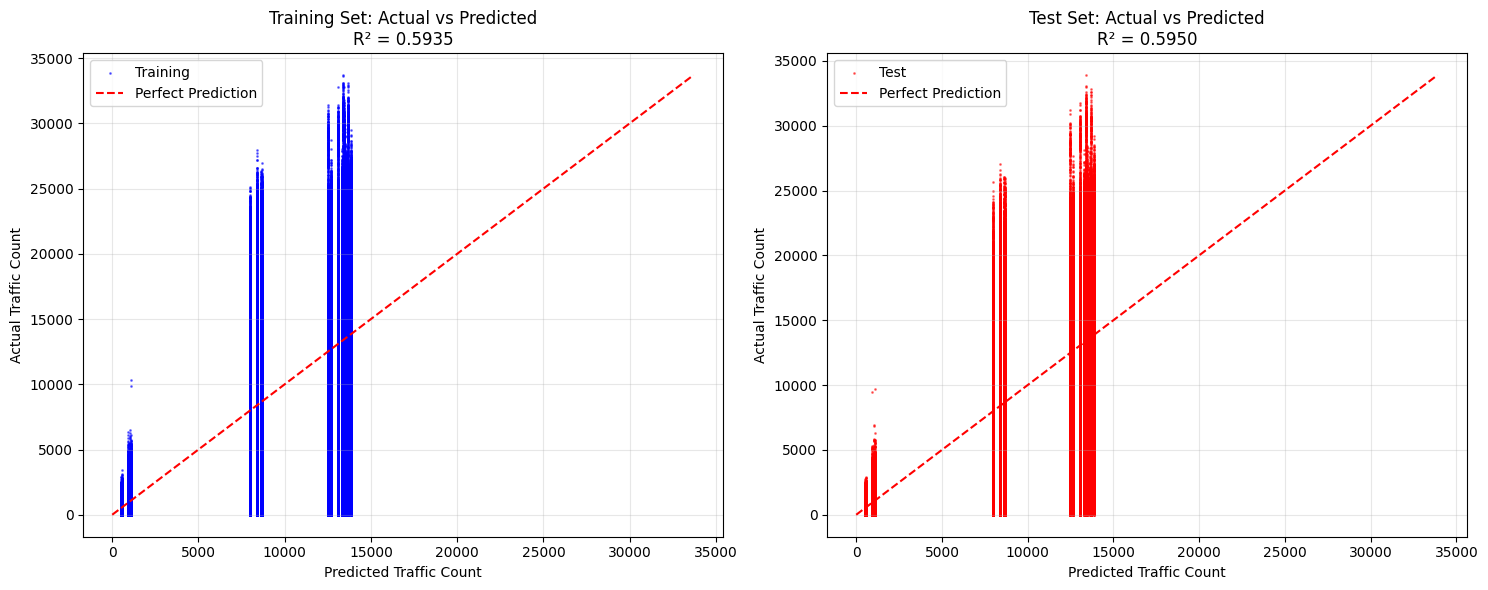

FIGURE 8-1: Decision Tree Actual vs Predicted Performance


/tmp/ipython-input-120007301.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


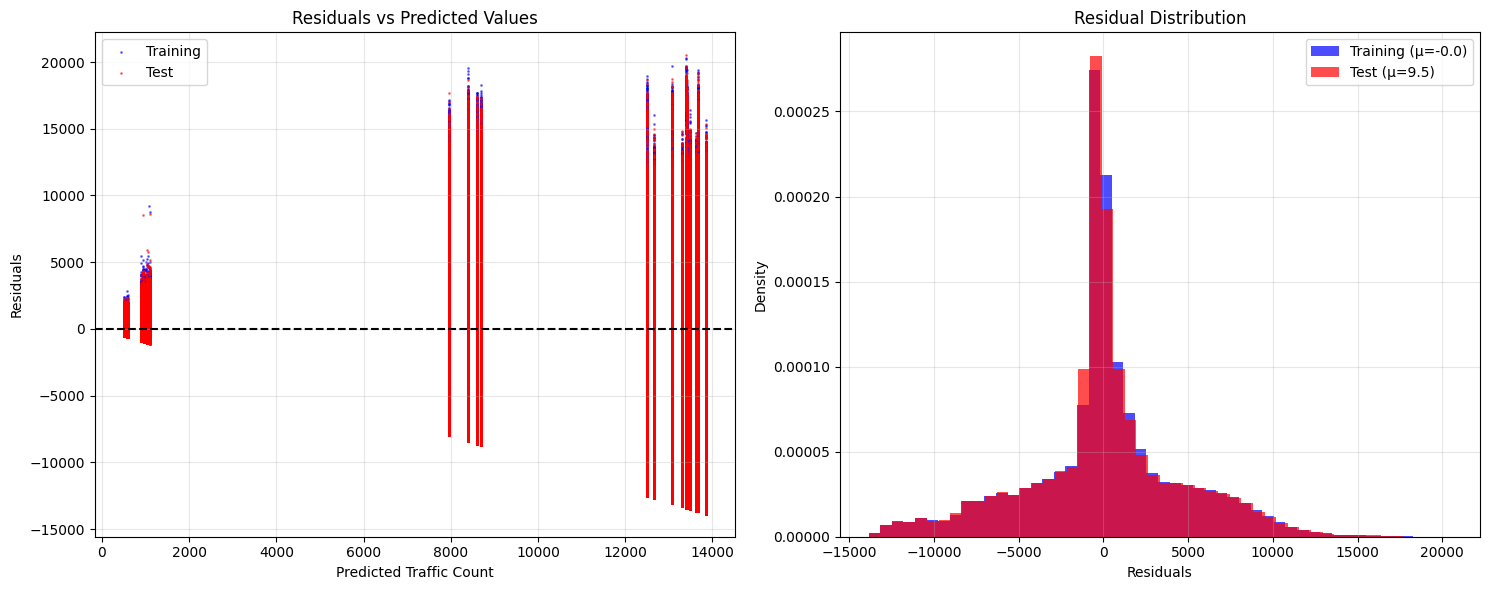

FIGURE 8-2: Decision Tree Residual Analysis


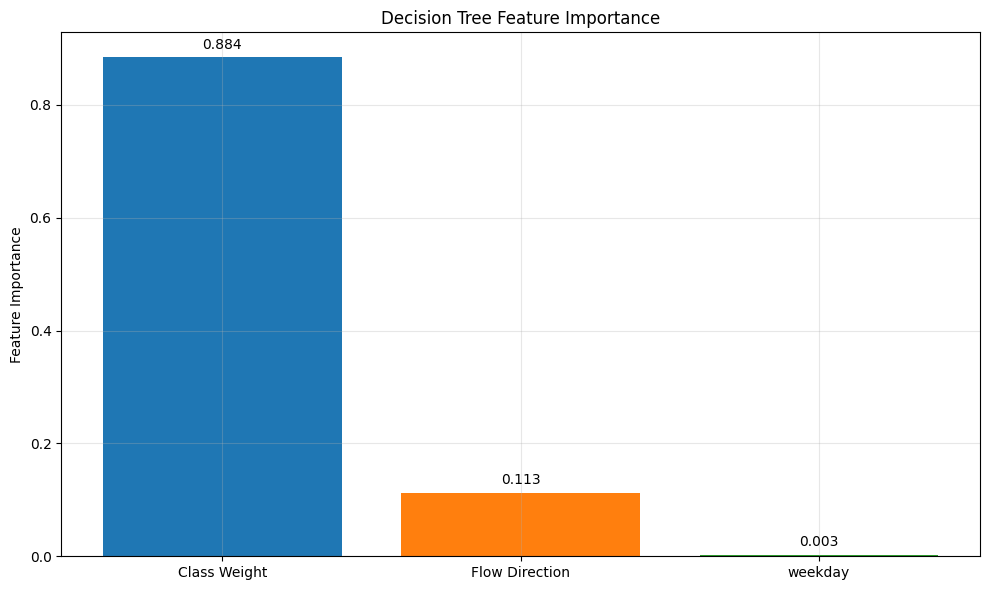

FIGURE 8-3: Decision Tree Feature Importance Rankings


In [11]:
print("\n8.2 VISUALISATION OF DATA, RESULTS, MODELS AND PATTERNS")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("\n8.2.1 Decision Tree Performance Visualizations")
print("-" * 45)

# Convert Spark DataFrames to Pandas for visualization
train_pandas = train_predictions_dt.select(COL_TARGET, "dt_prediction").toPandas()
test_pandas = test_predictions_dt.select(COL_TARGET, "dt_prediction").toPandas()

# Figure 8-1: Actual vs Predicted Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax1.scatter(train_pandas['dt_prediction'], train_pandas[COL_TARGET],
           alpha=0.5, s=1, color='blue', label='Training')
ax1.plot([0, train_pandas[COL_TARGET].max()], [0, train_pandas[COL_TARGET].max()],
         'r--', label='Perfect Prediction')
ax1.set_xlabel('Predicted Traffic Count')
ax1.set_ylabel('Actual Traffic Count')
ax1.set_title(f'Training Set: Actual vs Predicted\nR² = {train_r2_dt:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.scatter(test_pandas['dt_prediction'], test_pandas[COL_TARGET],
           alpha=0.5, s=1, color='red', label='Test')
ax2.plot([0, test_pandas[COL_TARGET].max()], [0, test_pandas[COL_TARGET].max()],
         'r--', label='Perfect Prediction')
ax2.set_xlabel('Predicted Traffic Count')
ax2.set_ylabel('Actual Traffic Count')
ax2.set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2_dt:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("FIGURE 8-1: Decision Tree Actual vs Predicted Performance")

# Figure 8-2: Residual Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate residuals
train_residuals = train_pandas[COL_TARGET] - train_pandas['dt_prediction']
test_residuals = test_pandas[COL_TARGET] - test_pandas['dt_prediction']

# Residuals vs Predicted
ax1.scatter(train_pandas['dt_prediction'], train_residuals, alpha=0.5, s=1,
           color='blue', label='Training')
ax1.scatter(test_pandas['dt_prediction'], test_residuals, alpha=0.5, s=1,
           color='red', label='Test')
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_xlabel('Predicted Traffic Count')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual histogram
ax2.hist(train_residuals, bins=50, alpha=0.7, color='blue',
         label=f'Training (μ={train_residuals.mean():.1f})', density=True)
ax2.hist(test_residuals, bins=50, alpha=0.7, color='red',
         label=f'Test (μ={test_residuals.mean():.1f})', density=True)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Density')
ax2.set_title('Residual Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("FIGURE 8-2: Decision Tree Residual Analysis")

# Figure 8-3: Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))
features = [pair[0] for pair in importance_pairs]
importances = [pair[1] for pair in importance_pairs]

bars = ax.bar(features, importances, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Feature Importance')
ax.set_title('Decision Tree Feature Importance')
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar, importance in zip(bars, importances):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{importance:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("FIGURE 8-3: Decision Tree Feature Importance Rankings")


8.2.3 Comprehensive Pattern Visualizations
---------------------------------------------


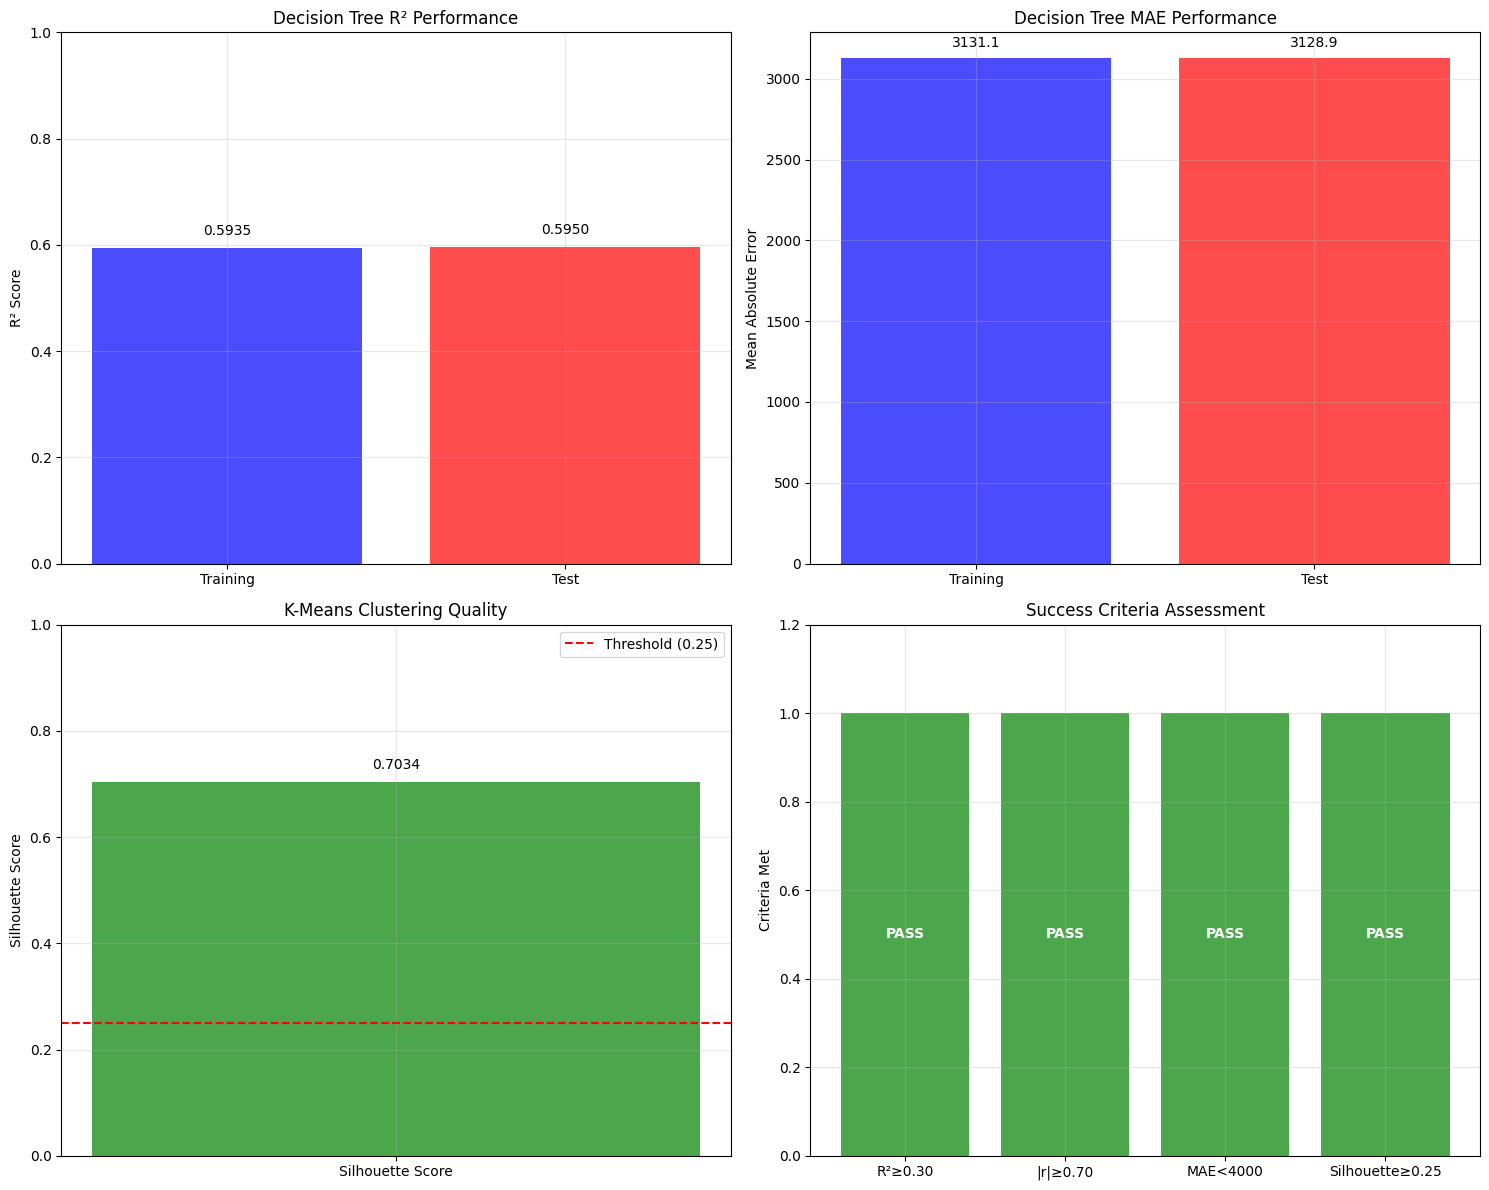

FIGURE 8-8: Comprehensive Model Performance Dashboard


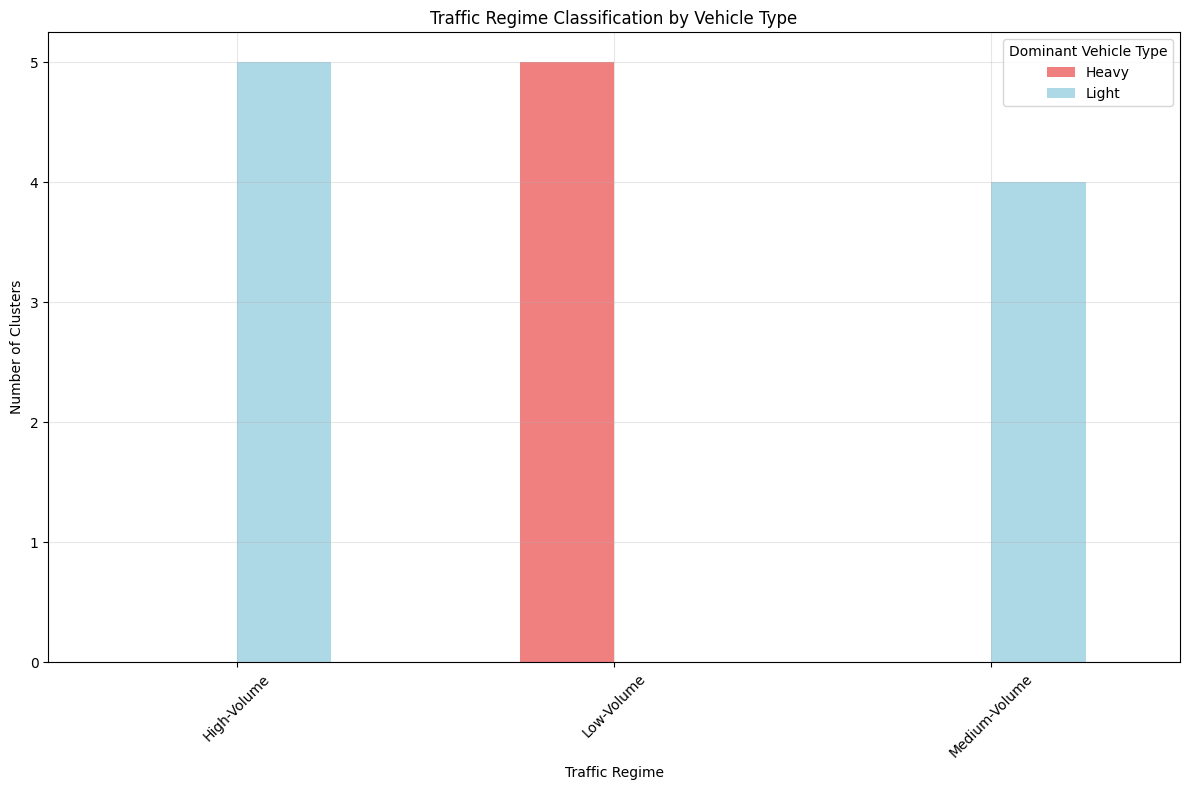

FIGURE 8-9: Traffic Regime Classification Matrix

8.2.4 Visualization Summary
------------------------------
Generated 9 comprehensive figures:
- Decision Tree performance and diagnostics (Figures 8-1 to 8-3)
- K-Means clustering patterns and distributions (Figures 8-4 to 8-7)
- Integrated model assessment and regime analysis (Figures 8-8 to 8-9)
All visualizations support pattern interpretation in subsequent sections.


In [12]:
print("\n8.2.3 Comprehensive Pattern Visualizations")
print("-" * 45)

# Figure 8-8: Model Performance Comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
models = ['Training', 'Test']
r2_values = [train_r2_dt, test_r2_dt]
ax1.bar(models, r2_values, color=['blue', 'red'], alpha=0.7)
ax1.set_ylabel('R² Score')
ax1.set_title('Decision Tree R² Performance')
ax1.set_ylim(0, 1)
for i, v in enumerate(r2_values):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')
ax1.grid(True, alpha=0.3)

# MAE comparison
mae_values = [train_mae_dt, test_mae_dt]
ax2.bar(models, mae_values, color=['blue', 'red'], alpha=0.7)
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('Decision Tree MAE Performance')
for i, v in enumerate(mae_values):
    ax2.text(i, v + 50, f'{v:.1f}', ha='center', va='bottom')
ax2.grid(True, alpha=0.3)

# Clustering quality metrics
ax3.bar(['Silhouette Score'], [silhouette_score], color='green', alpha=0.7)
ax3.axhline(y=0.25, color='red', linestyle='--', label='Threshold (0.25)')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('K-Means Clustering Quality')
ax3.set_ylim(0, 1)
ax3.text(0, silhouette_score + 0.02, f'{silhouette_score:.4f}', ha='center', va='bottom')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Success criteria summary
criteria = ['R²≥0.30', '|r|≥0.70', 'MAE<4000', 'Silhouette≥0.25']
status = [test_r2_dt >= 0.30, abs(test_corr_dt) >= 0.70, test_mae_dt < 4000, silhouette_score >= 0.25]
colors = ['green' if s else 'red' for s in status]

ax4.bar(criteria, [1]*len(criteria), color=colors, alpha=0.7)
ax4.set_ylabel('Criteria Met')
ax4.set_title('Success Criteria Assessment')
ax4.set_ylim(0, 1.2)
for i, (crit, stat) in enumerate(zip(criteria, status)):
    ax4.text(i, 0.5, 'PASS' if stat else 'FAIL', ha='center', va='center',
             fontweight='bold', color='white')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("FIGURE 8-8: Comprehensive Model Performance Dashboard")

# Figure 8-9: Traffic Regime Classification
fig, ax = plt.subplots(figsize=(12, 8))

# Create traffic regime classification
cluster_info_df = pd.DataFrame(cluster_data)
cluster_info_df['traffic_regime'] = cluster_info_df['avg_traffic'].apply(
    lambda x: 'High-Volume' if x > 10000 else 'Medium-Volume' if x > 3000 else 'Low-Volume'
)

# Count by regime and vehicle type
regime_vehicle = cluster_info_df.groupby(['traffic_regime', 'dominant_class']).size().unstack(fill_value=0)

regime_vehicle.plot(kind='bar', ax=ax, color=['lightcoral', 'lightblue'])
ax.set_xlabel('Traffic Regime')
ax.set_ylabel('Number of Clusters')
ax.set_title('Traffic Regime Classification by Vehicle Type')
ax.legend(title='Dominant Vehicle Type')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("FIGURE 8-9: Traffic Regime Classification Matrix")

print("\n8.2.4 Visualization Summary")
print("-" * 30)
print("Generated 9 comprehensive figures:")
print("- Decision Tree performance and diagnostics (Figures 8-1 to 8-3)")
print("- K-Means clustering patterns and distributions (Figures 8-4 to 8-7)")
print("- Integrated model assessment and regime analysis (Figures 8-8 to 8-9)")
print("All visualizations support pattern interpretation in subsequent sections.")